In [34]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
# from tensorflow.python.client import device_lib
# print(tf.__version__,tf.keras.__version__) # 2.10.0 / 2.10.0
# print(device_lib.list_local_devices()) # gtx 1660 / com capa 7.5 
from keras.models import Model
from keras.layers import Lambda,GaussianNoise,Activation,Dense,Input,Reshape,BatchNormalization
from keras.applications import VGG16,ResNet50V2
import keras.applications.resnet_v2 as resnet
import keras.applications.vgg16 as vgg
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import matplotlib.pyplot as plt
import itertools
import PIL.Image as Image

In [67]:
#### Config Values ###

IMG_SHAPE = (224,224,3)
BATCH_SIZE = 32
EPOCHS = 40
SHUFFLE = True
SEED = 42
CLASSES =['cats'] # for OC-CNN
CLASSES_t =['unknown','cats','dogs'] # for BoN-CNN
CLASSES_b =['raccoons','cats','dogs'] # for Bon test
TRAIN_PATH = r"./data/train/"
TEST_PATH = r"./data/test/"

In [64]:
### utills 

def wrap_generator(generator): # for OC-CNN
    while True:
        x,y = next(generator)
        y = tf.keras.utils.to_categorical(y)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.])
        y = tf.concat([y,zeros], axis=0)
        yield x,y

def get_label_test(test_gen):
    test_num = test_gen.samples
    label_test = []
    for i in range((test_num // test_gen.batch_size)+1):
        X,y = test_gen.next()
        label_test.append(y)
            
    label_test = np.argmax(np.vstack(label_test), axis=1)
    print(label_test.shape)
    
    return label_test

# https://ndb796.tistory.com/653
def calc_mean_std(feat, eps=1e-5):
    n, c = feat.shape[0], 1
    feat_var = np.var(feat.reshape(n, c, -1), axis=2) + eps
    feat_std = tf.sqrt(feat_var).reshape(n, c, 1, 1)
    feat_mean = tf.math.reduce_mean(feat.reshape(n, c, -1), axis=2).reshape(n, c, 1, 1)
    
    return feat_mean, feat_std
    
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues,cm_proba=True):
        if cm_proba:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=25)
        #plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
        plt.yticks(tick_marks, classes, fontsize=15)

        fmt = '.2f'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize = 14)

        plt.ylabel('True label', fontsize=20)
        plt.xlabel('Predicted label', fontsize=20)

def plot_confusion_matrix_detail(cm,classes):
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plot_confusion_matrix(cm,classes)
    plt.subplot(122)
    plot_confusion_matrix(cm,classes,cm_proba=False)
    
def sample_from_derectory(base_path=TEST_PATH,labels=CLASSES_b): # func only this file
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    samples = []
    for ax in axes.ravel():
        label = np.random.choice(os.listdir(base_path))
        i = np.where(np.array(labels)==label)[0]
        img = np.random.choice(os.listdir(base_path + label))
        img = Image.open(base_path + label + "/" + img) # os.path.join
        img = img.resize(IMG_SHAPE[:2],resample=Image.Resampling.NEAREST)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label+" "+str(i))  
        samples.append(np.array(img))
    
    return np.array(samples)

def plot_result(samples,preds,true_label=None,labels=CLASSES_b):
    f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))
    
    for i,ax in enumerate(axes.ravel()):
        label = labels[preds[i]]
        l = preds[i]
        img = Image.fromarray(samples[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("P : "+label+" "+str(l))  


In [6]:
# custom normalize layer : tensorflow에 inm 없음

class InstanceNormalize(tf.keras.layers.Layer):
    def __init__(self):
        super(InstanceNormalize, self).__init__()
        if self._compute_dtype not in ("float16", "bfloat16", "float32", None):
            raise ValueError(
                "Passing `fused=True` is only supported when the compute "
                "dtype is float16, bfloat16, or float32. Got dtype: %s"
                % (self._compute_dtype,)
            )
    def instanceNormalize(self,feat,shape, eps=1e-5): # c : local var
        n = shape[0]
        c = 1
        feat_var = tf.math.reduce_variance(tf.reshape(feat,(n, c, -1)), axis=2) + eps
        feat_std = tf.reshape(tf.sqrt(feat_var),(n, c, 1))
        feat_mean = tf.reshape(tf.math.reduce_mean(tf.reshape(feat,(n, c, -1)), axis=2),(n, c, 1))

        out = (feat - feat_mean) / feat_std
        return out

    def build(self, input_shape):
        pass

    def call(self, inputs):
        inputs = tf.cast(inputs, self.compute_dtype)
        original_shape = tf.shape(inputs)
        return self.instanceNormalize(inputs,original_shape)

def instanceNormalize(feat, eps=1e-5):
    
    n, c = feat.shape[0], 1
    feat_var = tf.math.reduce_variance(tf.reshape(feat,(n, c, -1)), axis=2) + eps
    feat_std = tf.reshape(tf.sqrt(feat_var),(n, c, 1))
    feat_mean = tf.reshape(tf.math.reduce_mean(tf.reshape(feat,(n, c, -1)), axis=2),(n, c, 1))

    out = (feat - feat_mean) / feat_std
    return out


In [79]:
#### Models ###

# BoN
def get_model_bon(train=True):
    pre_process = Lambda(vgg.preprocess_input)
    vgg16 = VGG16(weights = 'imagenet', include_top = True, input_shape = IMG_SHAPE)
    vgg16 = Model(vgg16.input, vgg16.layers[-3].output)
    vgg16.trainable = False
    
    inp = Input(IMG_SHAPE)
    vgg_16_process = pre_process(GaussianNoise(1e-8)(inp))
    vgg_out = vgg16(vgg_16_process)
    
    noise = Lambda(tf.zeros_like)(vgg_out)
    noise = GaussianNoise(0.01)(noise)

    if train:
        vgg_out = Reshape((1,4096))(vgg_out)
        vgg_out = InstanceNormalize()(vgg_out)
        vgg_out = Reshape((-1,))(vgg_out)
        x = Lambda(lambda z: tf.concat(z, axis=0))([vgg_out,noise])
        x = Activation('relu')(x)
    else:
        x = vgg_out

    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(3, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(  tf.keras.optimizers.Adam(lr=1e-4),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    return model

# OC-CNN+
def get_model_main(train=True):
    pre_process = Lambda(vgg.preprocess_input)
    vgg16 = VGG16(weights = 'imagenet', include_top = True, input_shape = IMG_SHAPE)
    vgg16 = Model(vgg16.input, vgg16.layers[-3].output)
    vgg16.trainable = False
    
    inp = Input(IMG_SHAPE)
    vgg_16_process = pre_process(GaussianNoise(1e-8)(inp))
    vgg_out = vgg16(vgg_16_process)
    
    noise = Lambda(tf.zeros_like)(vgg_out)
    noise = GaussianNoise(0.01)(noise)

    if train:
        vgg_out = Reshape((1,4096))(vgg_out)
        vgg_out = InstanceNormalize()(vgg_out)
        vgg_out = Reshape((-1,))(vgg_out)
        x = Lambda(lambda z: tf.concat(z, axis=0))([vgg_out,noise])
        x = Activation('relu')(x)
    else:
        x = vgg_out

    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(  tf.keras.optimizers.Adam(lr=1e-4),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    return model

# Binary classification model
def get_model_cnn(train=True):
    pre_process = Lambda(vgg.preprocess_input)
    vgg16 = VGG16(weights = 'imagenet', include_top = True, input_shape = IMG_SHAPE)
    vgg16 = Model(vgg16.input, vgg16.layers[-3].output)
    vgg16.trainable = False
    
    inp = Input(IMG_SHAPE)
    vgg_16_process = pre_process(GaussianNoise(1e-8)(inp))
    vgg_out = vgg16(vgg_16_process)
    
    if train:
        vgg_out = Reshape((1,4096))(vgg_out)
        vgg_out = InstanceNormalize()(vgg_out)
        x = Reshape((-1,))(vgg_out)
    else:
        x = vgg_out

    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(  tf.keras.optimizers.Adam(lr=1e-4),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics=['accuracy'])
    
    return model

# OC-CNN의 확장으로 전통적 이진 분류의 문제점을 개선
## Recognition of Unknown Labels: Expansion of OC-CNN
### - 학습되지 않은 이미지를 Unknown label로 예측합니다.
### - 훈련 이미지 : cats 300, dogs 300
### - 테스트 이미지 : cats 1000, dogs 1000, unknown(raccoons) 195
### - Acc : 87%

In [23]:
### Define Dataset Generator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = SHUFFLE,
            seed=SEED,
            classes = CLASSES_t
        )
test_generator = test_datagen.flow_from_directory(
            TEST_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = False,
            classes = CLASSES_b
        )

print(train_generator.classes[np.random.randint(600,size=10)])

Found 600 images belonging to 3 classes.
Found 2195 images belonging to 3 classes.
[2 2 2 2 1 2 1 1 2 2]


In [19]:
### Fake label for Bon
def wrap_generator_bon(generator):
    while True:
        x,y = next(generator)
        zeros = tf.zeros_like(y) + tf.constant([1.,0.,0.])
        y = tf.concat([y,zeros], axis=0)
        yield x,y
 

In [20]:
### Train BoN

train_model = get_model_bon(True)
with tf.device("/device:GPU:0"):
    train_model.fit(wrap_generator_bon(train_generator),
                        steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                        epochs=40)

Epoch 1/40


c:\Users\zxcas\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


18/18 [==============================] - 11s 332ms/step - loss: 0.6954 - accuracy: 0.5242
Epoch 2/40
18/18 [==============================] - 3s 183ms/step - loss: 0.5385 - accuracy: 0.9950
Epoch 3/40
18/18 [==============================] - 3s 182ms/step - loss: 0.4970 - accuracy: 1.0000
Epoch 4/40
18/18 [==============================] - 3s 182ms/step - loss: 0.4543 - accuracy: 0.9983
Epoch 5/40
18/18 [==============================] - 4s 187ms/step - loss: 0.4036 - accuracy: 0.9992
Epoch 6/40
18/18 [==============================] - 4s 202ms/step - loss: 0.3433 - accuracy: 1.0000
Epoch 7/40
18/18 [==============================] - 4s 208ms/step - loss: 0.2782 - accuracy: 1.0000
Epoch 8/40
18/18 [==============================] - 4s 210ms/step - loss: 0.2168 - accuracy: 0.9983
Epoch 9/40
18/18 [==============================] - 4s 192ms/step - loss: 0.1635 - accuracy: 1.0000
Epoch 10/40
18/18 [==============================] - 4s 202ms/step - loss: 0.1197 - accuracy: 1.0000
Epoch 11/

In [24]:
### BoN Test

pred_model = get_model_bon(train=False)
pred_model.set_weights(train_model.get_weights())
ground_truth = get_label_test(test_generator)
pred_test = np.argmax(pred_model.predict(test_generator), axis=1)
main_acc = accuracy_score(ground_truth, pred_test)
print('ACCURACY:', main_acc)

c:\Users\zxcas\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(2195,)
69/69 [==============================] - 15s 214ms/step
ACCURACY: 0.8697038724373576


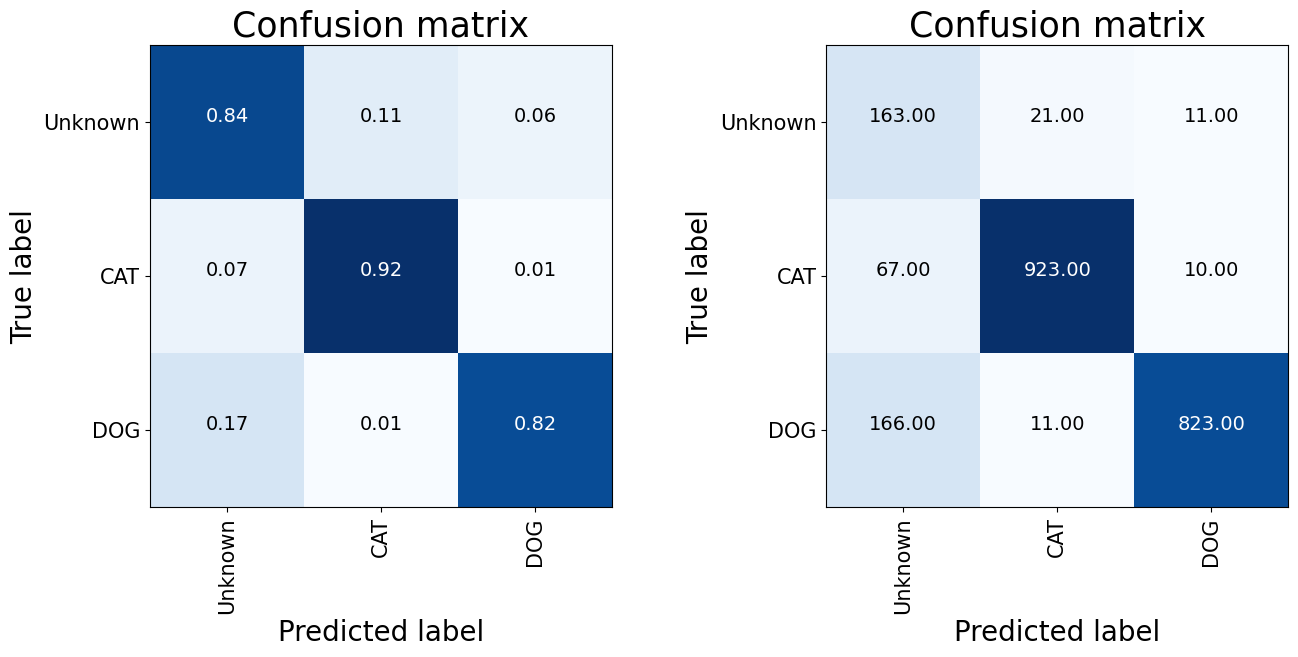

              precision    recall  f1-score   support

    raccoons       0.41      0.84      0.55       195
        cats       0.97      0.92      0.94      1000
        dogs       0.98      0.82      0.89      1000

    accuracy                           0.87      2195
   macro avg       0.78      0.86      0.80      2195
weighted avg       0.92      0.87      0.89      2195



In [57]:
### classification report

cnf_matrix = confusion_matrix(ground_truth, pred_test)
plot_confusion_matrix_detail(cnf_matrix, classes=['Unknown','CAT','DOG'])
plt.show()
print(classification_report(ground_truth,pred_test,target_names=test_generator.class_indices.keys()))

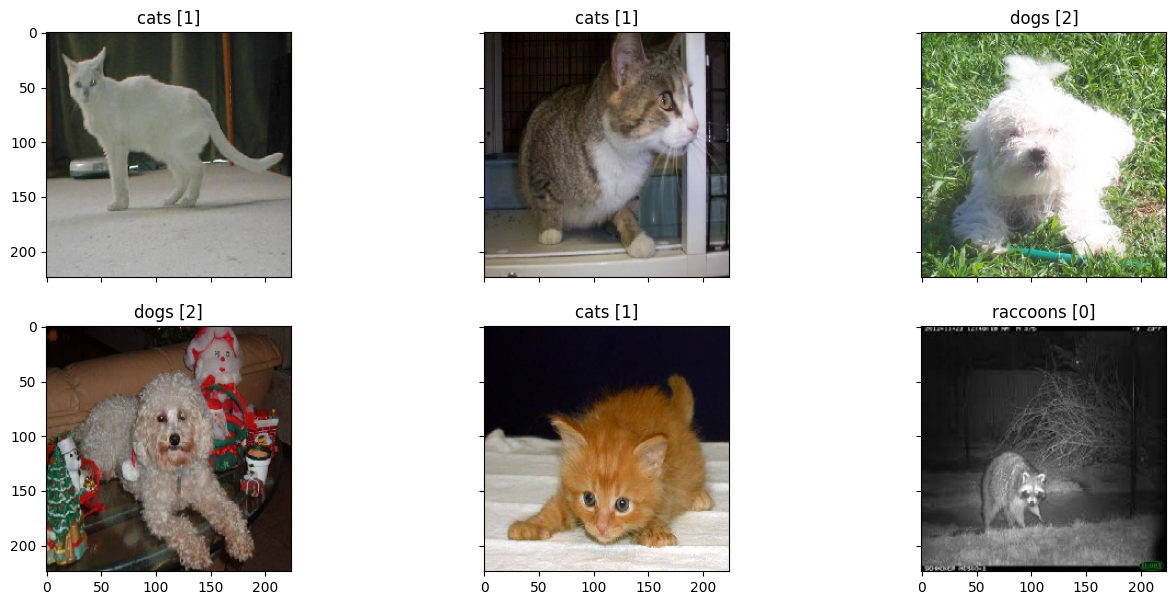

In [55]:
# Sample test

samples = sample_from_derectory()

1/1 [==============================] - 0s 27ms/step


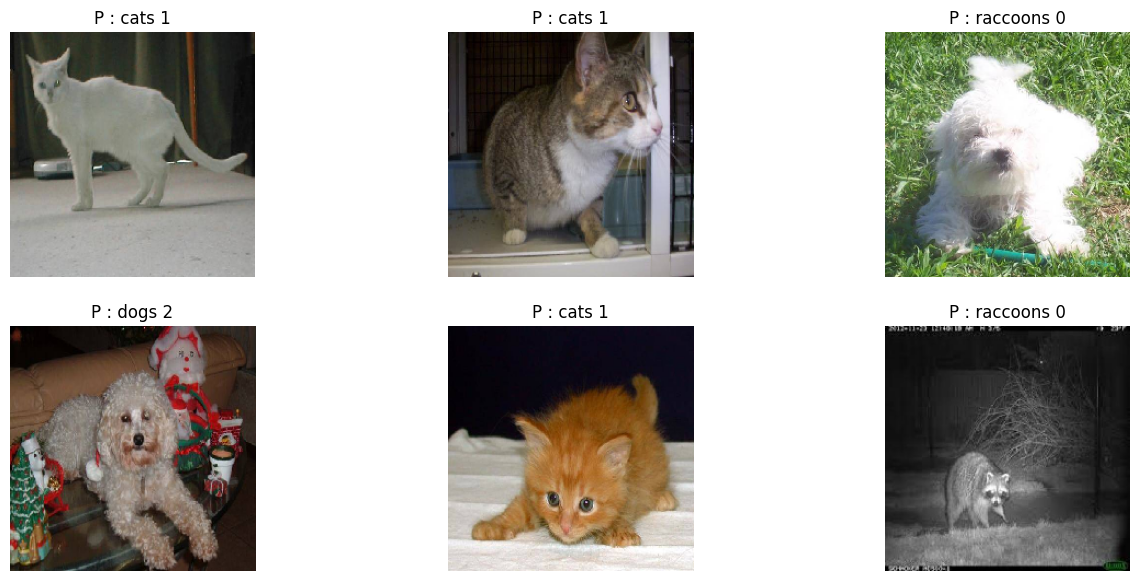

In [63]:
# Predict samples and plot result

sample_preds = pred_model.predict(samples)
preds = np.argmax(sample_preds,axis=1)
plot_result(samples,preds)

# OC-CNN+ : 해당 논문의 네트워크를 일부 수정 
### - 훈련 이미지 : cats 300
### - 테스트 이미지 : cats 1000, dogs(unknown) 1000
### - Acc : 94%

In [66]:
### Define Dataset Generator

train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = SHUFFLE,
            seed=SEED,
            classes = CLASSES
        )
test_generator = test_datagen.flow_from_directory(
            TEST_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = False,
            classes = [CLASSES_b[2],CLASSES_b[1]]
        )

print(train_generator.classes[np.random.randint(300,size=10)])

Found 300 images belonging to 1 classes.
Found 2000 images belonging to 2 classes.
[0 0 0 0 0 0 0 0 0 0]


In [68]:
### Train

train_model = get_model_main()
with tf.device("/device:GPU:0"):
    train_model.fit(wrap_generator(train_generator),
                        steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                        epochs=EPOCHS)

Epoch 1/40


c:\Users\zxcas\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


9/9 [==============================] - 5s 396ms/step - loss: 0.5794 - accuracy: 0.5050
Epoch 2/40
9/9 [==============================] - 2s 208ms/step - loss: 0.3554 - accuracy: 0.5000
Epoch 3/40
9/9 [==============================] - 2s 205ms/step - loss: 0.3459 - accuracy: 0.7833
Epoch 4/40
9/9 [==============================] - 2s 183ms/step - loss: 0.3331 - accuracy: 1.0000
Epoch 5/40
9/9 [==============================] - 2s 183ms/step - loss: 0.3177 - accuracy: 1.0000
Epoch 6/40
9/9 [==============================] - 2s 184ms/step - loss: 0.2985 - accuracy: 1.0000
Epoch 7/40
9/9 [==============================] - 2s 184ms/step - loss: 0.2765 - accuracy: 1.0000
Epoch 8/40
9/9 [==============================] - 2s 181ms/step - loss: 0.2518 - accuracy: 1.0000
Epoch 9/40
9/9 [==============================] - 2s 187ms/step - loss: 0.2272 - accuracy: 1.0000
Epoch 10/40
9/9 [==============================] - 2s 206ms/step - loss: 0.2030 - accuracy: 1.0000
Epoch 11/40
9/9 [=============

In [70]:
### Test

pred_model = get_model_main(train=False)
pred_model.set_weights(train_model.get_weights())
ground_truth = get_label_test(test_generator)
pred_test = np.argmax(pred_model.predict(test_generator), axis=1)
main_acc = accuracy_score(ground_truth, pred_test)
print('ACCURACY:', main_acc)

c:\Users\zxcas\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(2000,)
63/63 [==============================] - 14s 217ms/step
ACCURACY: 0.9395


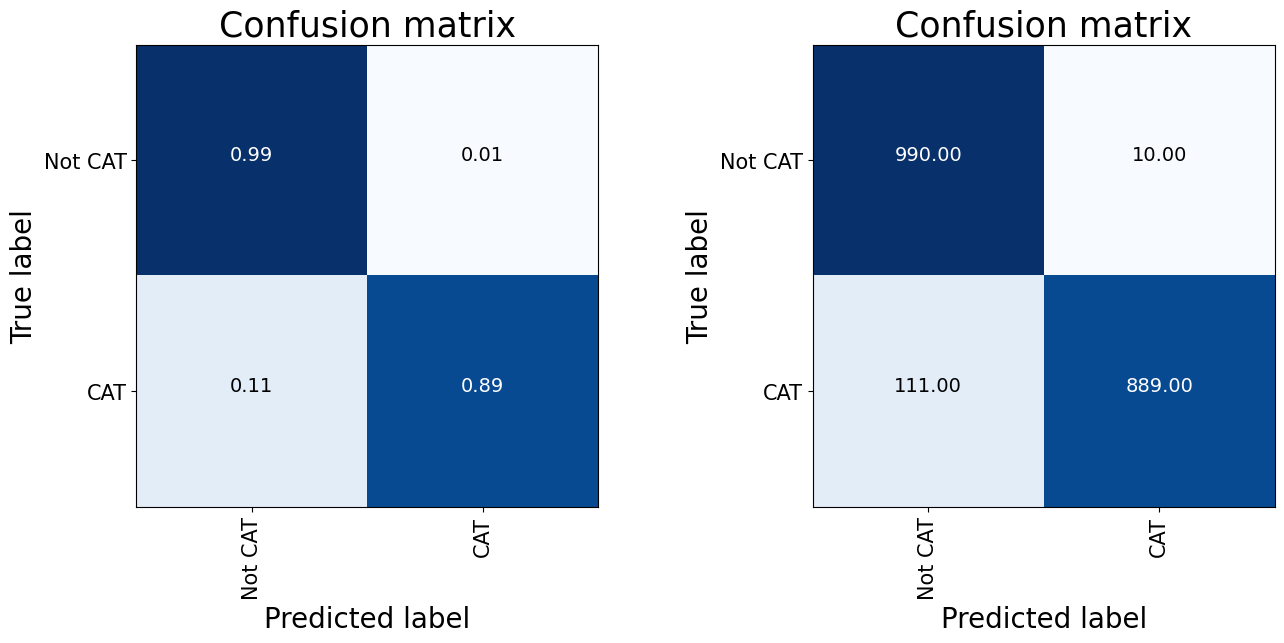

              precision    recall  f1-score   support

        dogs       0.90      0.99      0.94      1000
        cats       0.99      0.89      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [72]:
### classification report

cnf_matrix = confusion_matrix(ground_truth, pred_test)
plot_confusion_matrix_detail(cnf_matrix, classes=['Not CAT','CAT'])
plt.show()
print(classification_report(ground_truth,pred_test,target_names=test_generator.class_indices.keys()))

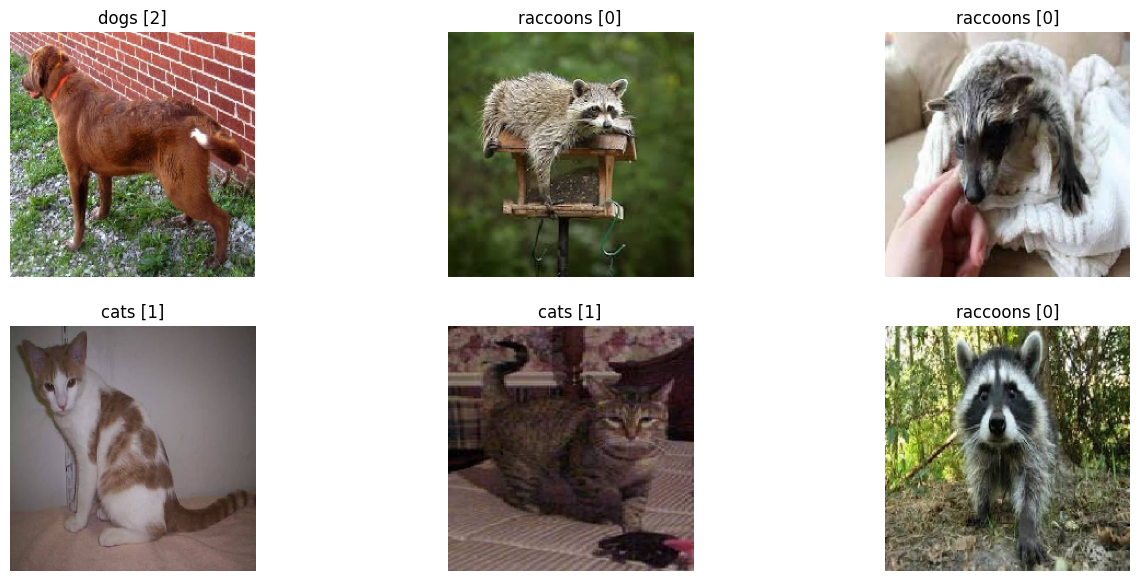

In [73]:
# Sample test 
# * cats : 1 / dogs,raccoons : 0

samples = sample_from_derectory()

1/1 [==============================] - 0s 43ms/step


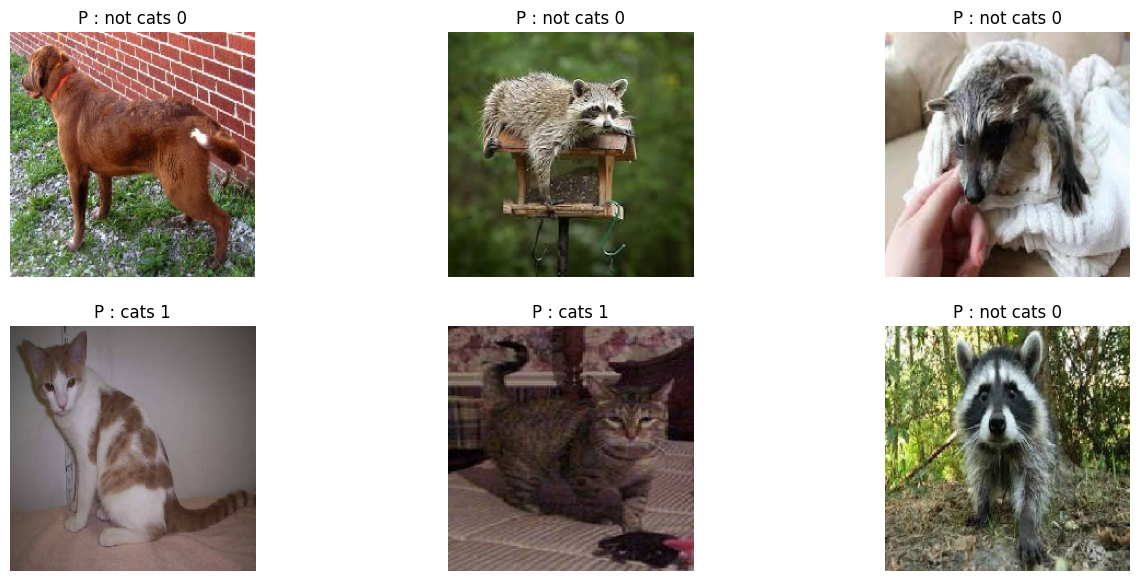

In [75]:
# Predict samples and plot result

sample_preds = pred_model.predict(samples)
preds = np.argmax(sample_preds,axis=1)
plot_result(samples,preds,labels=['not cats','cats'])

# CNN : 이진분류 CNN
### - 훈련 이미지 : cats 300, dogs 300
### - 테스트 이미지 : cats 1000, dogs 1000
### - Acc : 

In [77]:
### Define Dataset Generator

train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = SHUFFLE,
            seed=SEED,
            classes = [CLASSES_b[2],CLASSES_b[1]]
        )
test_generator = test_datagen.flow_from_directory(
            TEST_PATH,
            target_size = (IMG_SHAPE[0], IMG_SHAPE[1]),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = False,
            classes = [CLASSES_b[2],CLASSES_b[1]]
        )

print(train_generator.classes[np.random.randint(600,size=10)])

Found 600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
[1 0 0 0 0 0 1 1 0 0]


In [80]:
### Train

train_model = get_model_cnn()
with tf.device("/device:GPU:0"):
    train_model.fit(train_generator,
                        steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                        epochs=EPOCHS)

Epoch 1/40


c:\Users\zxcas\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


18/18 [==============================] - 5s 196ms/step - loss: 0.2397 - accuracy: 0.8900
Epoch 2/40
18/18 [==============================] - 4s 196ms/step - loss: 0.0123 - accuracy: 0.9967
Epoch 3/40
18/18 [==============================] - 3s 181ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 4/40
18/18 [==============================] - 3s 179ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 5/40
18/18 [==============================] - 3s 178ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 6/40
18/18 [==============================] - 3s 178ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 7/40
18/18 [==============================] - 3s 178ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 8/40
18/18 [==============================] - 3s 178ms/step - loss: 8.9839e-04 - accuracy: 1.0000
Epoch 9/40
18/18 [==============================] - 3s 179ms/step - loss: 7.8339e-04 - accuracy: 1.0000
Epoch 10/40
18/18 [==============================] - 3s 178ms/step - loss: 6.8975e-04 - accuracy: 1.000

In [83]:
### Test

pred_model = get_model_cnn(train=False)
pred_model.set_weights(train_model.get_weights())
ground_truth = get_label_test(test_generator)
pred_test = np.argmax(pred_model.predict(test_generator), axis=1)
main_acc = accuracy_score(ground_truth, pred_test)
print('ACCURACY:', main_acc)

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
### classification report

cnf_matrix = confusion_matrix(ground_truth, pred_test)
plot_confusion_matrix_detail(cnf_matrix, classes=['Not CAT','CAT'])
plt.show()
print(classification_report(ground_truth,pred_test,target_names=test_generator.class_indices.keys()))

In [ ]:
# Sample test 
# * cats : 1 / dogs,raccoons : 0

samples = sample_from_derectory()

In [ ]:
# Predict samples and plot result

sample_preds = pred_model.predict(samples)
preds = np.argmax(sample_preds,axis=1)
plot_result(samples,preds,labels=['not cats','cats'])

### Reference
### - Oza, Poojan, and Vishal M. Patel. "One-class convolutional neural network." IEEE Signal Processing Letters 26.2 (2018): 277-281.
### - https://github.com/otkupjnoz/oc-cnn